In [1]:
## set specific GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [2]:
from tensorflow import keras
from keras import layers
from PIL import Image
from natsort import natsorted
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import KFold
from random import randrange
from functools import partial

import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import re as regex
import os
import pathlib
import itertools
import sys

sys.path.append('/tf/local_modules')
import importlib
import dataloders
from dataloders import test
importlib.reload(dataloders)

print(tf.__version__)
print(tf.keras.__version__)

2025-01-07 11:39:24.814824: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2025-01-07 11:39:25.807289: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2025-01-07 11:39:25.807402: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2025-01-07 11:39:25.807416: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


2.11.1
2.11.0


In [3]:
tf.config.list_physical_devices(
    device_type='GPU'
)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Load multi spectral scenes

In [4]:
UV_FILTER = ["nofilter"]    
SWIR_FILTER = ["nofilter","1000nm","1300nm","1450nm", "1550nm"]
VIS_FILTER = ["nofilter_r", "nofilter_g", "nofilter_b"]
VIS_NIR_FILTER = ["nofilter", "740nm","845nm","880nm", "940nm"]
SPECTRUM = ["VIS_[0-5][0-9]", "VIS_NIR", "SWIR", "UV"]

uv_filter_regex = list(map(regex.compile, UV_FILTER))
swir_filter_regex = list(map(regex.compile, SWIR_FILTER))
vis_filter_regex = list(map(regex.compile, VIS_FILTER))
vis_nir_filter_regex = list(map(regex.compile, VIS_NIR_FILTER))
spectrum_regex = list(map(regex.compile, SPECTRUM))

In [5]:
# sorting the image paths for one multi sepctral scene
def sort_channel_paths(channel_paths):
    sorted_path_list = [None] * 14
    mask = None
    for cp in channel_paths:
        if cp.split('/')[-2] == 'masks':
            mask = cp
        
        else:
            channel_name = cp.split('/')[-1]
            if spectrum_regex[0].search(channel_name):
                if vis_filter_regex[0].search(channel_name):
                    sorted_path_list[0] = cp
                elif vis_filter_regex[1].search(channel_name):
                    sorted_path_list[1] = cp
                elif vis_filter_regex[2].search(channel_name):
                    sorted_path_list[2] = cp
                else:
                    print(channel_name, 'VIS filter not found')
                    sys.exit()
                    
            elif spectrum_regex[1].search(channel_name):
                if vis_nir_filter_regex[0].search(channel_name):
                    sorted_path_list[3] = cp
                elif vis_nir_filter_regex[1].search(channel_name):
                    sorted_path_list[4] = cp
                elif vis_nir_filter_regex[2].search(channel_name):
                    sorted_path_list[5] = cp
                elif vis_nir_filter_regex[3].search(channel_name):
                    sorted_path_list[6] = cp
                elif vis_nir_filter_regex[4].search(channel_name):
                    sorted_path_list[7] = cp
                else:
                    print(cp, 'VIS_NIR filter not found')
                    sys.exit()
            
            elif spectrum_regex[2].search(channel_name):
                 if swir_filter_regex[0].search(channel_name):
                     sorted_path_list[8] = cp 
                 elif swir_filter_regex[1].search(channel_name):
                     sorted_path_list[9] = cp
                 elif swir_filter_regex[2].search(channel_name):
                     sorted_path_list[10] = cp
                 elif swir_filter_regex[3].search(channel_name):
                     sorted_path_list[11] = cp
                 elif swir_filter_regex[4].search(channel_name):
                     sorted_path_list[12] = cp
                 else:
                    print(cp, 'SWIR filter not found')
                    sys.exit()

            elif spectrum_regex[3].search(channel_name):
                if uv_filter_regex[0].search(channel_name):
                    sorted_path_list[13] = cp
                else:
                    print(cp, 'UV filter not found')
                    sys.exit()
        
            
            else:
                print(cp, 'spectrum not found')
                sys.exit()
    
    if mask is None:
        print('MSI of', channel_paths[0], 'contains no mask')
        sys.exit()
    if None in sorted_path_list:
        print('MSI of', channel_paths[0], 'does not contain all channels')
        sys.exit()
    return sorted_path_list, mask

In [6]:
# load one image of an multi spectral scene as tensor
def imgpath_to_tensor(path, channels=1):
    img_file = tf.io.read_file(path)
    img = tf.io.decode_png(
        contents = img_file,
        channels = channels,
        dtype = tf.dtypes.uint8,
    )
    
    return img


In [7]:
# mapping numeric labels, pixel values and alphabetic labels for MaterialID.md
NUMERIC_CLASS_LABELS= [0, 10, 11, 20, 21, 30, 31, 60, 61, 40, 41, 50, 51, 70, 71,\
                      80, 81, 90, 91, 110, 111]
WRITTEN_CLASS_LABELS = ['unbekannt',\
                        'vermutlich Vermischtes', 'sehr wahrscheinlich Vermischtes',\
                        'vermutlich Plastik', 'sehr wahrscheinlich Plastik',\
                        'vermutlich Pappe', 'sehr wahrscheinlich Pappe',\
                        'vermutlich Textilen', 'sehr wahrscheinlich Textilien',\
                        'vermutlich Holz', 'sehr wahrscheinlich Holz',\
                        'vermutlich Metall', 'sehr wahrscheinlich Metall',\
                        'vermutlich Schaumstoff', 'sehr wahrscheinlich Schaumstoff',\
                        'vermutlich Mineralstoff', 'sehr wahrscheinlich Mineralstoff',\
                        'vermutlich Batterien', 'sehr wahrscheinlich Batterien',\
                        'vermutlich Hintergrund', 'sehr wahrscheinlich Hintergrund'\
]
WRITTEN_AND_NUMERIC_LABELS = list(zip(NUMERIC_CLASS_LABELS, WRITTEN_CLASS_LABELS))
print(*WRITTEN_AND_NUMERIC_LABELS, sep='\n')

(0, 'unbekannt')
(10, 'vermutlich Vermischtes')
(11, 'sehr wahrscheinlich Vermischtes')
(20, 'vermutlich Plastik')
(21, 'sehr wahrscheinlich Plastik')
(30, 'vermutlich Pappe')
(31, 'sehr wahrscheinlich Pappe')
(60, 'vermutlich Textilen')
(61, 'sehr wahrscheinlich Textilien')
(40, 'vermutlich Holz')
(41, 'sehr wahrscheinlich Holz')
(50, 'vermutlich Metall')
(51, 'sehr wahrscheinlich Metall')
(70, 'vermutlich Schaumstoff')
(71, 'sehr wahrscheinlich Schaumstoff')
(80, 'vermutlich Mineralstoff')
(81, 'sehr wahrscheinlich Mineralstoff')
(90, 'vermutlich Batterien')
(91, 'sehr wahrscheinlich Batterien')
(110, 'vermutlich Hintergrund')
(111, 'sehr wahrscheinlich Hintergrund')


In [8]:
def print_label_stats(ds_version):# get all existing classes
    path = [list(pathlib.Path(scene).glob('registered_scene/masks/*.png'))[0] for scene in ds_version]
    path = [str(p) for p in path]
    masks_t = path
    masks_t = list(map(imgpath_to_tensor, masks_t))
    masks_t = [tf.reshape(mask, [-1]) for mask in masks_t]
    masks_t = tf.concat(masks_t, axis=-1)

    existing_labels, idx = tf.unique(masks_t)
    existing_labels = sorted(existing_labels.numpy().tolist())
    print("existing labels", existing_labels)

    used_labels =  existing_labels[1:]
    print("used_labls", used_labels)
     

    print()
    label, _, count = tf.unique_with_counts(masks_t)
    print("counting labels", sorted(list(zip(label.numpy().tolist(), count.numpy().tolist()))))
    
    sum_labels = 0
    for l, c in sorted(list(zip(label.numpy().tolist(), count.numpy().tolist())))[1:]:
        sum_labels += c
    print("summ existing labels", sum_labels)
    
    print()
    print(*WRITTEN_AND_NUMERIC_LABELS, sep='\n')

In [9]:
# Schaumstoff is ignored
used_labels = [21, 31, 41, 51, 61, 71, 81]
used_labels_written = ['plasitc', 'paper', 'wood', 'metal', 'textiles', 'foam', 'minerals']

In [10]:
handsome_labels = list(set([int(l/10) for l in NUMERIC_CLASS_LABELS[3:-5]]))
print(handsome_labels)
handsome_labels = [l -2 for l in handsome_labels]
handsome_labels

[2, 3, 4, 5, 6, 7, 8]


[0, 1, 2, 3, 4, 5, 6]

In [11]:

handsome_labels_written = ['unbekannt', 'vermischtes', 'plastic', 'paper', 'wood', 'metal', 'textiles',
                           'foam', 'minerals' ]
print(handsome_labels_written)
handsome_labels_written = handsome_labels_written[2:]
handsome_labels_written

['unbekannt', 'vermischtes', 'plastic', 'paper', 'wood', 'metal', 'textiles', 'foam', 'minerals']


['plastic', 'paper', 'wood', 'metal', 'textiles', 'foam', 'minerals']

In [12]:
# Gnerate patches from image
# original is from https://keras.io/examples/vision/masked_image_modeling/
# exmaple is adapted to create 3-D insted of 1-D patches
class MSI3DBorderPatches(layers.Layer):
    def __init__(self, patch_size, border_size=0, channels=14, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.channels = channels
        self.border_size = border_size

        self.resize = layers.Reshape((-1, patch_size * patch_size, 
                                      self.channels))

    def call(self, images):
        # Create patches from the input images
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size - self.border_size*2, self.patch_size - self.border_size*2, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )

        # Reshape the patches to (batch, num_patches, patch_x, patch_y, patch_channel) and return it.
        patches = self.resize(patches)
        patches = tf.reshape(patches, (patches.shape[0], patches.shape[1], self.patch_size, self.patch_size, self.channels))
        if self.border_size and self.channels == 1:
            inner_patch_size = self.patch_size - self.border_size*2
            patches = tf.cast(tf.squeeze(patches, axis=0), tf.dtypes.float32)

            patches = tf.image.extract_glimpse(patches, size=(inner_patch_size, inner_patch_size), 
                                               offsets=[[-inner_patch_size//2, -inner_patch_size//2]]*patches.shape[0],
                                               centered=True, normalized=False)
            patches = tf.expand_dims(patches, axis=0)
            patches = tf.cast(patches, tf.dtypes.uint8)

        return patches

    def __select_image_channel__(self, img, lidx=0):
        channel = img[: , : , lidx]
        channel = tf.expand_dims(channel, axis=-1)
        return channel
        
    def show_patched_image(self, images, layer_idx, patches, vmax=255):
        # This is a utility function which accepts a batch of images and its
        # corresponding patches and help visualize one image and its patches
        # side by side.
        
        idx = np.random.choice(patches.shape[0])
        print(f"Index selected: {idx}.")

        img_channel = self.__select_image_channel__(images[idx], layer_idx)
        
        plt.figure(figsize=(8, 8))
        plt.imshow(keras.utils.array_to_img(img_channel, scale=False), cmap='gray', vmin=0, vmax=vmax)
        plt.axis("off")
        plt.show()

        nx = int(img_channel.shape[0] / self.patch_size) 
        ny =  int(img_channel.shape[1] / self.patch_size)
        patches = patches[:,:,:,:,layer_idx]
        plt.figure(figsize=(8, 8))
        for i, patch in enumerate(patches[idx]):
            ax = plt.subplot(nx, ny, i + 1)
            patch_img = patch
            plt.imshow(keras.utils.img_to_array(patch_img),cmap='gray', vmin=0, vmax=vmax)
            plt.axis("off")
        plt.show()

        # Return the index chosen to validate it outside the method.
        return idx

    # taken from https://stackoverflow.com/a/58082878/10319735
    def reconstruct_from_patch(self, patch, img_size, layer_idx):
        # This utility function takes patches from a *single* image and
        # reconstructs it back into the image. This is useful for the train
        # monitor callback.
        print(patch.shape, 'patch shape')
        print(img_size, 'img size')
        num_patches = patch.shape[0]
        nx = int( (img_size[0] - self.border_size * 2) / self.patch_size) 
        ny =  int( (img_size[1] - self.border_size * 2) / self.patch_size)
        #nx = 94
        patch = patch[:,:,:,layer_idx]
        rows = tf.split(patch, nx, axis=0)
        rows = [tf.concat(tf.unstack(x), axis=1) for x in rows]
        reconstructed = tf.concat(rows, axis=0)
        return reconstructed

In [13]:
def index_of(e):
    return NUMERIC_CLASS_LABELS.index(e)


class PatchDatasetBuilder():
    
    def __init__(self, msi_dirs, balance, labels, batch_size, patch_size=16, border_size=0):
        self.msi_dirs = msi_dirs
        self.balanced = balance
        self.labels = labels
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.border_size = border_size
    
    def __load_pixels__(self):
        
        if(type(self.msi_dirs[0] == str)):
            self.msi_dirs = [pathlib.Path(p) for p in self.msi_dirs]
        
    
        for msi_d in self.msi_dirs:
            channel_paths, mask_path = sort_channel_paths([str(p) for p in msi_d.glob('registered_scene/*/*.png')])
            msi_as_list_of_tensors = list(map(imgpath_to_tensor, channel_paths))
            msi_as_tensor =  tf.concat(msi_as_list_of_tensors, axis=-1)

            img_patches = MSI3DBorderPatches(patch_size=self.patch_size, border_size=self.border_size)\
                            (images=tf.expand_dims(msi_as_tensor, axis=0))

            mask = Image.open(mask_path)
            mask = np.asarray(mask)
            mask_shape = mask.shape
            mask = mask.flatten()
            mask_as_tensor = tf.constant(mask, dtype=tf.uint8)
            mask_as_tensor = tf.reshape(mask_as_tensor, (mask_shape[0], mask_shape[1], 1))


            mask_patches = MSI3DBorderPatches(channels=1, patch_size=self.patch_size, border_size = self.border_size)\
                             (images=tf.expand_dims(mask_as_tensor, axis=0))
            
            img_patches = tf.squeeze(img_patches)
            mask_patches = tf.squeeze(mask_patches)
            
            
            #remove patches containing only background
            indices = tf.where(tf.not_equal(tf.squeeze(mask_patches), tf.constant(0, dtype=tf.uint8)))
            indices, _ = tf.unique(indices[:,0])
            
            materials = tf.gather(mask_patches, indices=indices)
            materials = tf.squeeze(materials)
           
            img_patches = tf.gather(img_patches, indices=indices)
            
            yield img_patches, materials
            
    
    def __create_base_dataset__(self):
        # pull data
        data = list(itertools.islice(self.__load_pixels__(), None))
        
        x= []
        y = []
        
        for pixels, labels in data:
            x.append(pixels)
            y.append(labels)

        
        x = tf.concat(x, axis=0)
        y = tf.concat(y, axis=0)
        base_ds = tf.data.Dataset.from_tensor_slices((x, y))\
                    .shuffle(buffer_size=len(x))\
                    .map(lambda x, y : (x, y//10 - 2))                  
        return base_ds, len(x)
    

        
    def get_dataset(self):
        base_ds, ds_length = self.__create_base_dataset__()

      
        return   base_ds\
                .take(-1)\
                .batch(self.batch_size)\
                .prefetch(tf.data.AUTOTUNE)

In [14]:
def save_best_model(name, init_threshold):
    
    return keras.callbacks.ModelCheckpoint(
        'models/'+name,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
        mode="auto",
        save_freq="epoch",
        initial_value_threshold=init_threshold,
    )

In [15]:
class RepetitiveTrainer():
    def __init__(self, model_func, iterations, epochs=200, save_model_name="", es_patience=10, es_start=0):
        self.model_func = model_func
        self.iterations = iterations
        self.epochs = epochs
        self.early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=es_patience, start_from_epoch=es_start,)
        self.histories = []
        self.save_model_name = save_model_name
    
    
    def __plot_history__(self,index):
        # copied from https://www.tensorflow.org/tutorials/images/transfer_learning
        history = self.histories[index]
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']

        loss = history.history['loss']
        val_loss = history.history['val_loss']

        plt.figure(figsize=(8, 8))
        plt.subplot(2, 1, 1)
        plt.plot(acc, label='Training Accuracy')
        plt.plot(val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.ylabel('Accuracy')
        plt.ylim([min(plt.ylim()),1])
        plt.title('Training and Validation Accuracy')

        plt.subplot(2, 1, 2)
        plt.plot(loss, label='Training Loss')
        plt.plot(val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.ylabel('Cross Entropy')
        plt.ylim([0,1.0])
        plt.title('Training and Validation Loss')
        plt.xlabel('epoch')
        plt.show()

        max_val = max(val_acc)
        max_val_index = np.argmax(val_acc)
        train_on_max_val = acc[max_val_index]
        max_val_epoch = max_val_index + 1

        print(f'highest validation accuracy {max_val * 100:.2f}')
        print(f'with train accuracy {train_on_max_val * 100:.2f}')
        print('on epoch', max_val_epoch)

    
    def train(self, train_ds, val_ds, ds_name):
        min_val_acc = 0.40
        callbacks = [self.early_stopping]
        for it in range(self.iterations):
            if self.save_model_name != "":
                smc = save_best_model(name=self.save_model_name + "_"+ds_name, init_threshold=min_val_acc)
                callbacks = [self.early_stopping, smc]
            new_model = self.model_func()
            hist = new_model.fit(train_ds, epochs=self.epochs,
                validation_data=val_ds, 
                      callbacks=callbacks, 
                      shuffle=False,
            )
            min_val_acc = max(max(hist.history['val_accuracy']), min_val_acc)
            self.histories.append(hist)
            print("-------------------NEXT ITERATION--------------------")
    
    
    def show_results(self, indices=None):
        history = self.histories
        if indices:
            history = history[indices[0]:indices[1]]
            
        max_val_accs = [round(max(hist.history['val_accuracy'] * 10),2) for hist in history]
        max_val_per_iteration = list(zip(range(len(max_val_accs)), max_val_accs))
        print("max val_acc per iteration:",  max_val_per_iteration)
        print("highest val_acc:", max(max_val_accs))
        print("mean max:", tf.math.reduce_mean(max_val_accs, axis=0), \
              "std_dev:", tf.math.reduce_std(max_val_accs, axis=0))
        if indices:
            self.__plot_history__(indices[0] + max_val_accs.index(max(max_val_accs)))
    

In [16]:
class ManualSplitTrainer():
    def __init__(self, train_test_pairs, ds_builder, ds_names = [], patch_size=16, border_size=0, batch_size=128):
        self.train_test_pairs = train_test_pairs
        self.ds_builder = ds_builder
        self.datasets = []
        self.repetitions = len(train_test_pairs)
        self.patch_size = patch_size
        self.border_size = border_size
        self.batch_size = batch_size
        
        if len(ds_names) > 0:
            self.ds_names = ds_names
        else:
            self.ds_names = [""] * len(train_test_pairs)
        self.__build__datasets__()
        
    def __build__datasets__(self):
        self.datasets = []
        for i, (train_dirs, test_dirs) in enumerate(self.train_test_pairs):
    
            train_ds = self.ds_builder(train_dirs, balance=False,\
                                       labels=used_labels, batch_size=self.batch_size,\
                                       patch_size = self.patch_size, border_size=self.border_size
                                       ).get_dataset()
            
            test_ds = self.ds_builder(test_dirs, balance=False,\
                                     labels=used_labels, batch_size=self.batch_size,
                                     patch_size = self.patch_size, border_size=self.border_size

                                     ).get_dataset()
            
            self.datasets.append((train_ds, test_ds))
    
    def train(self, trainer):
        for i, (train_ds, test_ds) in enumerate(self.datasets):
            print('#################################')
            print('          Split ',i)
            print('#################################')

            trainer.train(train_ds, test_ds, ds_name = self.ds_names[i])
    
    
    def show_results(self, trainer):    
        its=trainer.iterations
        for s in range(len(self.train_test_pairs)):
            print("--------Results for split", s, "---------------")
            indices = (s * its, s * its + its)
            trainer.show_results(indices)

In [17]:
MSIv5_BASE_PATH = "../datasets/MSIv5/UV_VIS_SWIR/"

In [18]:
skipp_msiv5_darkroom = [
    #chessboard only
    "24_03_14_darkroom/recording/24_03_14_13_16_40",
    # to much textiles, curtain is labeld
    "24_03_14_darkroom/recording/24_03_14_16_21_25",
    "24_03_14_darkroom/recording/24_03_14_16_42_23",
    "24_03_14_darkroom/recording/24_03_14_16_46_10",
    "24_03_14_darkroom/recording/24_03_14_17_00_26",
    "24_03_14_darkroom/recording/24_03_14_17_29_41",
    "24_03_14_darkroom/recording/24_03_14_17_37_00",
    "24_03_14_darkroom/recording/24_03_14_17_46_08",
    "24_03_14_darkroom/recording/24_03_14_17_49_23",
    "24_03_14_darkroom/recording/24_03_14_17_58_14",
    "24_03_14_darkroom/recording/24_03_14_18_01_26",
    "24_03_14_darkroom/recording/24_03_14_18_05_06",
    "24_03_14_darkroom/recording/24_03_14_18_09_13"
]
skipp_msiv5_darkroom = [ MSIv5_BASE_PATH + p for p in skipp_msiv5_darkroom]

val_msiv5_darkroom = [
    # all object are in train
    "24_03_14_darkroom/recording/24_03_14_14_04_06",
    
    # most objects seem to be in train
    "24_03_14_darkroom/recording/24_03_14_14_24_11",
    "24_03_14_darkroom/recording/24_03_14_17_21_44"
]
val_msiv5_darkroom = [MSIv5_BASE_PATH + p for p in val_msiv5_darkroom]

train_msiv5_darkroom =[str(p) for p in pathlib.Path( MSIv5_BASE_PATH + "24_03_14_darkroom").glob('recording/*/')
                      if p.is_dir()] 
train_msiv5_darkroom = [p for p in train_msiv5_darkroom if p not in skipp_msiv5_darkroom + val_msiv5_darkroom]


In [19]:
print(len(train_msiv5_darkroom), len(val_msiv5_darkroom))

14 3


In [20]:
# print number of labed pixels for each class
print_label_stats(train_msiv5_darkroom)

2025-01-07 11:39:27.890093: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-07 11:39:28.137726: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 23786 MB memory:  -> device: 0, name: Quadro P6000, pci bus id: 0000:05:00.0, compute capability: 6.1


existing labels [0, 21, 31, 41, 51, 61, 81]
used_labls [21, 31, 41, 51, 61, 81]

counting labels [(0, 34461550), (21, 916905), (31, 955337), (41, 749144), (51, 1156379), (61, 3157055), (81, 489908)]
summ existing labels 7424728

(0, 'unbekannt')
(10, 'vermutlich Vermischtes')
(11, 'sehr wahrscheinlich Vermischtes')
(20, 'vermutlich Plastik')
(21, 'sehr wahrscheinlich Plastik')
(30, 'vermutlich Pappe')
(31, 'sehr wahrscheinlich Pappe')
(60, 'vermutlich Textilen')
(61, 'sehr wahrscheinlich Textilien')
(40, 'vermutlich Holz')
(41, 'sehr wahrscheinlich Holz')
(50, 'vermutlich Metall')
(51, 'sehr wahrscheinlich Metall')
(70, 'vermutlich Schaumstoff')
(71, 'sehr wahrscheinlich Schaumstoff')
(80, 'vermutlich Mineralstoff')
(81, 'sehr wahrscheinlich Mineralstoff')
(90, 'vermutlich Batterien')
(91, 'sehr wahrscheinlich Batterien')
(110, 'vermutlich Hintergrund')
(111, 'sehr wahrscheinlich Hintergrund')


In [21]:
print_label_stats(val_msiv5_darkroom)

existing labels [0, 21, 31, 41, 51, 61, 81]
used_labls [21, 31, 41, 51, 61, 81]

counting labels [(0, 7961475), (21, 274516), (31, 213772), (41, 240344), (51, 115986), (61, 74411), (81, 95127)]
summ existing labels 1014156

(0, 'unbekannt')
(10, 'vermutlich Vermischtes')
(11, 'sehr wahrscheinlich Vermischtes')
(20, 'vermutlich Plastik')
(21, 'sehr wahrscheinlich Plastik')
(30, 'vermutlich Pappe')
(31, 'sehr wahrscheinlich Pappe')
(60, 'vermutlich Textilen')
(61, 'sehr wahrscheinlich Textilien')
(40, 'vermutlich Holz')
(41, 'sehr wahrscheinlich Holz')
(50, 'vermutlich Metall')
(51, 'sehr wahrscheinlich Metall')
(70, 'vermutlich Schaumstoff')
(71, 'sehr wahrscheinlich Schaumstoff')
(80, 'vermutlich Mineralstoff')
(81, 'sehr wahrscheinlich Mineralstoff')
(90, 'vermutlich Batterien')
(91, 'sehr wahrscheinlich Batterien')
(110, 'vermutlich Hintergrund')
(111, 'sehr wahrscheinlich Hintergrund')


In [22]:
# prin example image paths
print(val_msiv5_darkroom[0])
print(skipp_msiv5_darkroom[0])
print(train_msiv5_darkroom[0])

../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_14_04_06
../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_13_16_40
../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_14_17_09


In [23]:
n_classes = len(handsome_labels)

# Calculate Class Weights and define weighted loss

In [24]:
class WeightedModel(keras.Model):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
        self.train_metrics= [
            keras.metrics.SparseCategoricalAccuracy(name="accuracy")
        ]
        
        

    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value.
            # The loss function is configured in `compile()`.
            loss = self.compute_loss(
                y=y,
                y_pred=y_pred,
            )
            
        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        for metric in self.metrics:
            if metric.name != "loss":
                y, y_pred = self.__clear_dirty_labels__(y, y_pred)
                metric.update_state(y, y_pred)
                
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}
    
    
    def __clear_dirty_labels__(self, y, y_pred): # delete unlabeld regions for acc claclculation
        clean_idx = tf.where(tf.not_equal(y, 254))
        clean_y = tf.gather_nd(y, clean_idx)
        clean_y_pred = tf.gather_nd(y_pred, clean_idx)
        
        return clean_y, clean_y_pred
    
    
    def test_step(self, data):
        # Unpack the data
        x, y = data
        # Compute predictions
        y_pred = self(x, training=False)
        # Updates the metrics tracking the loss
        self.compute_loss(y=y, y_pred=y_pred)
        # Update the metrics.
        for metric in self.metrics:
            if metric.name != "loss":
                y, y_pred = self.__clear_dirty_labels__(y, y_pred)
                metric.update_state(y, y_pred)
            
        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}

In [25]:
BATCH_SIZE = 128

In [26]:
man_train = ManualSplitTrainer(train_test_pairs=[
                                                    (train_msiv5_darkroom, val_msiv5_darkroom)
                                                ],
                               ds_names=["msi_v5_darkroom"],
                               ds_builder=PatchDatasetBuilder, patch_size=24, border_size=4,
                                           batch_size=BATCH_SIZE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [27]:
def  calc__batch_size_class_weights(ds):
        labels = []
        for msi, lbl in ds:
            labels.append(tf.reshape(lbl, [-1]))
        
        labels = tf.concat(labels, axis=0)
        labels = tf.cast(labels, tf.dtypes.float64)
        
        classes, _, count = tf.unique_with_counts(labels)
        classes = sorted(tf.cast(classes, tf.dtypes.float64).numpy().tolist())
        
        non_bg_idx = tf.where(tf.not_equal(labels, tf.constant(254, tf.dtypes.float64)))
        non_bg_labels = tf.squeeze(tf.gather(labels, non_bg_idx))
        
        weights = compute_class_weight('balanced', classes=classes[:-1], y=non_bg_labels.numpy())
        
        class_weights = {}

        for c,w in zip(classes[:-1], weights):
            class_weights[int(c)] = w
        
        class_weights[5] = 0.0
        
        class_weights = dict(list(sorted(class_weights.items())))
        print(class_weights)
        
        batch_size_class_weights = []
        for w in class_weights.values():
            batch_size_class_weights.append(tf.constant(w, shape=(1, BATCH_SIZE*16*16), dtype=tf.dtypes.float32))
        
        batch_size_class_weights = tf.concat(batch_size_class_weights, axis=0)
        return class_weights, batch_size_class_weights

In [28]:
class_weights, batch_class_weights = calc__batch_size_class_weights(man_train.datasets[0][0]) #clalc class_weight

{0: 1.3477421941840504, 1: 1.2969039116925443, 2: 1.6590591667144354, 3: 1.0585188906991574, 4: 0.39424983494400095, 5: 0.0, 6: 2.4812604271278147}


In [29]:
def pixel_weighted_cross_entropy(targets, predictions, class_weights, batch_weights):
    
    targets_f32 = tf.cast(targets, tf.dtypes.float32)
    targets_i32 = tf.cast(targets, tf.dtypes.int32)
    
    loss_val = keras.losses.sparse_categorical_crossentropy(targets_f32, predictions, ignore_class=254)
    targets_1d = tf.reshape(targets_i32, [-1])
    
    sample_weights = tf.zeros(tf.shape(targets), dtype=tf.dtypes.float32)
    for i, key in enumerate(class_weights.keys()):
        idx = tf.where(tf.math.equal(targets, key))
        sample_weights = tf.tensor_scatter_nd_update(sample_weights, idx, batch_weights[i][0:tf.shape(idx)[0]])
    
    weighted_loss_val = sample_weights * loss_val
    reduced_loss = tf.math.reduce_mean(weighted_loss_val)
    return reduced_loss

pwce_loss =  partial(pixel_weighted_cross_entropy, class_weights=class_weights, batch_weights=batch_class_weights)

In [30]:
# In paper reffered as spectrum module
class LightSpectral(tf.Module):
  def __init__(self, squeeze, expand1x1, depth_multiplier, name=None, padding='same'):
    super().__init__(name=name)
    self.padding = padding
    self.squeeze = layers.Conv2D(squeeze, (1,1), activation='relu')
    self.expand1x1 = layers.Conv2D(expand1x1, (1,1), activation='relu')
    self.expand3x3 = layers.DepthwiseConv2D((3,3), depth_multiplier=depth_multiplier,\
                                            activation='relu', padding=self.padding)
    self.concat = layers.Concatenate(axis=-1) 
  def __call__(self, x):
    s = self.squeeze(x)
    e1 = self.expand1x1(s)
    if self.padding == 'valid':
        e1 = layers.Cropping2D(cropping=(1))(e1)
    e3 = self.expand3x3(s) 
    return self.concat([e1,e3])

In [31]:
def create_spectrum_unet(loss=pwce_loss):
    input_shape=(24,24,14)
    input = keras.Input(shape=input_shape)
    x = layers.Rescaling(1./255)(input)
    x = layers.Conv2D(96, (2,2), strides=(2,2), activation='relu')(x)
    
    w = LightSpectral(32, 96, 1, name='spectral')(x)
    x = LightSpectral(32, 96, 1, name='spectral')(w)
    skip = layers.Add()([x,w])
    block1 = LightSpectral(32, 192, 2, name='spectral')(skip)#8x8
    
    w = layers.MaxPool2D((2,2), strides=(2,2))(block1)
    x = LightSpectral(32, 192, 2, name='spectral')(w)
    skip = layers.Add()([x,w])
    w = LightSpectral(48, 288, 2, name='spectral')(skip)
    x = LightSpectral(48, 288, 2, name='spectral')(w)
    skip = layers.Add()([x,w])
    block2 = LightSpectral(64, 384, 2, name='spectral')(skip)#4x4
    
    w = layers.MaxPool2D((2,2), strides=(2,2))(block2)
    x = LightSpectral(64, 384, 2, name='spectral')(w)
    skip = layers.Add()([x,w])#2x2
    
    
    up1 = layers.UpSampling2D(2)(skip)
    up1 = LightSpectral(64, 384, 2, name='spectral')(up1)
    up1 = layers.Concatenate()([block2, up1])
    up1 = LightSpectral(64, 384, 2, name='spectral')(up1)

    up2 = layers.UpSampling2D(2)(up1)
    up2 = LightSpectral(32, 192, 2, name='spectral')(up2)
    up2 = layers.Concatenate()([block1, up2])
    up2  = layers.Cropping2D(1)(up2)
    
    up3 = layers.UpSampling2D(2)(up2)
    up3 = LightSpectral(24, 74, 1, name='spectral')(up3)
    up3 = LightSpectral(24, 74, 1, name='spectral', padding='valid')(up3)

    out = layers.Conv2D(n_classes, 3, activation="softmax", padding='valid')(up3)
    
    slush = WeightedModel( inputs=input, outputs=out)
    slush.compile( optimizer="adam", loss=pwce_loss, run_eagerly=False)
    
    return slush


create_spectrum_unet().summary()

Model: "weighted_model"


__________________________________________________________________________________________________


 Layer (type)                   Output Shape         Param #     Connected to                     


 input_1 (InputLayer)           [(None, 24, 24, 14)  0           []                               


                                ]                                                                 


 rescaling (Rescaling)          (None, 24, 24, 14)   0           ['input_1[0][0]']                


 conv2d (Conv2D)                (None, 12, 12, 96)   5472        ['rescaling[0][0]']              


 conv2d_1 (Conv2D)              (None, 12, 12, 32)   3104        ['conv2d[0][0]']                 


 conv2d_2 (Conv2D)              (None, 12, 12, 96)   3168        ['conv2d_1[0][0]']               


 depthwise_conv2d (DepthwiseCon  (None, 12, 12, 32)  320         ['conv2d_1[0][0]']               


 v2D)                                                                                             


 concatenate (Concatenate)      (None, 12, 12, 128)  0           ['conv2d_2[0][0]',               


                                                                  'depthwise_conv2d[0][0]']       


 conv2d_3 (Conv2D)              (None, 12, 12, 32)   4128        ['concatenate[0][0]']            


 conv2d_4 (Conv2D)              (None, 12, 12, 96)   3168        ['conv2d_3[0][0]']               


 depthwise_conv2d_1 (DepthwiseC  (None, 12, 12, 32)  320         ['conv2d_3[0][0]']               


 onv2D)                                                                                           


 concatenate_1 (Concatenate)    (None, 12, 12, 128)  0           ['conv2d_4[0][0]',               


                                                                  'depthwise_conv2d_1[0][0]']     


 add (Add)                      (None, 12, 12, 128)  0           ['concatenate_1[0][0]',          


                                                                  'concatenate[0][0]']            


 conv2d_5 (Conv2D)              (None, 12, 12, 32)   4128        ['add[0][0]']                    


 conv2d_6 (Conv2D)              (None, 12, 12, 192)  6336        ['conv2d_5[0][0]']               


 depthwise_conv2d_2 (DepthwiseC  (None, 12, 12, 64)  640         ['conv2d_5[0][0]']               


 onv2D)                                                                                           


 concatenate_2 (Concatenate)    (None, 12, 12, 256)  0           ['conv2d_6[0][0]',               


                                                                  'depthwise_conv2d_2[0][0]']     


 max_pooling2d (MaxPooling2D)   (None, 6, 6, 256)    0           ['concatenate_2[0][0]']          


 conv2d_7 (Conv2D)              (None, 6, 6, 32)     8224        ['max_pooling2d[0][0]']          


 conv2d_8 (Conv2D)              (None, 6, 6, 192)    6336        ['conv2d_7[0][0]']               


 depthwise_conv2d_3 (DepthwiseC  (None, 6, 6, 64)    640         ['conv2d_7[0][0]']               


 onv2D)                                                                                           


 concatenate_3 (Concatenate)    (None, 6, 6, 256)    0           ['conv2d_8[0][0]',               


                                                                  'depthwise_conv2d_3[0][0]']     


 add_1 (Add)                    (None, 6, 6, 256)    0           ['concatenate_3[0][0]',          


                                                                  'max_pooling2d[0][0]']          


 conv2d_9 (Conv2D)              (None, 6, 6, 48)     12336       ['add_1[0][0]']                  


 conv2d_10 (Conv2D)             (None, 6, 6, 288)    14112       ['conv2d_9[0][0]']               


 depthwise_conv2d_4 (DepthwiseC  (None, 6, 6, 96)    960         ['conv2d_9[0][0]']               


 onv2D)                                                                                           


 concatenate_4 (Concatenate)    (None, 6, 6, 384)    0           ['conv2d_10[0][0]',              


                                                                  'depthwise_conv2d_4[0][0]']     


 conv2d_11 (Conv2D)             (None, 6, 6, 48)     18480       ['concatenate_4[0][0]']          


 conv2d_12 (Conv2D)             (None, 6, 6, 288)    14112       ['conv2d_11[0][0]']              


 depthwise_conv2d_5 (DepthwiseC  (None, 6, 6, 96)    960         ['conv2d_11[0][0]']              


 onv2D)                                                                                           


 concatenate_5 (Concatenate)    (None, 6, 6, 384)    0           ['conv2d_12[0][0]',              


                                                                  'depthwise_conv2d_5[0][0]']     


 add_2 (Add)                    (None, 6, 6, 384)    0           ['concatenate_5[0][0]',          


                                                                  'concatenate_4[0][0]']          


 conv2d_13 (Conv2D)             (None, 6, 6, 64)     24640       ['add_2[0][0]']                  


 conv2d_14 (Conv2D)             (None, 6, 6, 384)    24960       ['conv2d_13[0][0]']              


 depthwise_conv2d_6 (DepthwiseC  (None, 6, 6, 128)   1280        ['conv2d_13[0][0]']              


 onv2D)                                                                                           


 concatenate_6 (Concatenate)    (None, 6, 6, 512)    0           ['conv2d_14[0][0]',              


                                                                  'depthwise_conv2d_6[0][0]']     


 max_pooling2d_1 (MaxPooling2D)  (None, 3, 3, 512)   0           ['concatenate_6[0][0]']          


 conv2d_15 (Conv2D)             (None, 3, 3, 64)     32832       ['max_pooling2d_1[0][0]']        


 conv2d_16 (Conv2D)             (None, 3, 3, 384)    24960       ['conv2d_15[0][0]']              


 depthwise_conv2d_7 (DepthwiseC  (None, 3, 3, 128)   1280        ['conv2d_15[0][0]']              


 onv2D)                                                                                           


 concatenate_7 (Concatenate)    (None, 3, 3, 512)    0           ['conv2d_16[0][0]',              


                                                                  'depthwise_conv2d_7[0][0]']     


 add_3 (Add)                    (None, 3, 3, 512)    0           ['concatenate_7[0][0]',          


                                                                  'max_pooling2d_1[0][0]']        


 up_sampling2d (UpSampling2D)   (None, 6, 6, 512)    0           ['add_3[0][0]']                  


 conv2d_17 (Conv2D)             (None, 6, 6, 64)     32832       ['up_sampling2d[0][0]']          


 conv2d_18 (Conv2D)             (None, 6, 6, 384)    24960       ['conv2d_17[0][0]']              


 depthwise_conv2d_8 (DepthwiseC  (None, 6, 6, 128)   1280        ['conv2d_17[0][0]']              


 onv2D)                                                                                           


 concatenate_8 (Concatenate)    (None, 6, 6, 512)    0           ['conv2d_18[0][0]',              


                                                                  'depthwise_conv2d_8[0][0]']     


 concatenate_9 (Concatenate)    (None, 6, 6, 1024)   0           ['concatenate_6[0][0]',          


                                                                  'concatenate_8[0][0]']          


 conv2d_19 (Conv2D)             (None, 6, 6, 64)     65600       ['concatenate_9[0][0]']          


 conv2d_20 (Conv2D)             (None, 6, 6, 384)    24960       ['conv2d_19[0][0]']              


 depthwise_conv2d_9 (DepthwiseC  (None, 6, 6, 128)   1280        ['conv2d_19[0][0]']              


 onv2D)                                                                                           


 concatenate_10 (Concatenate)   (None, 6, 6, 512)    0           ['conv2d_20[0][0]',              


                                                                  'depthwise_conv2d_9[0][0]']     


 up_sampling2d_1 (UpSampling2D)  (None, 12, 12, 512)  0          ['concatenate_10[0][0]']         


 conv2d_21 (Conv2D)             (None, 12, 12, 32)   16416       ['up_sampling2d_1[0][0]']        


 conv2d_22 (Conv2D)             (None, 12, 12, 192)  6336        ['conv2d_21[0][0]']              


 depthwise_conv2d_10 (Depthwise  (None, 12, 12, 64)  640         ['conv2d_21[0][0]']              


 Conv2D)                                                                                          


 concatenate_11 (Concatenate)   (None, 12, 12, 256)  0           ['conv2d_22[0][0]',              


                                                                  'depthwise_conv2d_10[0][0]']    


 concatenate_12 (Concatenate)   (None, 12, 12, 512)  0           ['concatenate_2[0][0]',          


                                                                  'concatenate_11[0][0]']         


 cropping2d (Cropping2D)        (None, 10, 10, 512)  0           ['concatenate_12[0][0]']         


 up_sampling2d_2 (UpSampling2D)  (None, 20, 20, 512)  0          ['cropping2d[0][0]']             


 conv2d_23 (Conv2D)             (None, 20, 20, 24)   12312       ['up_sampling2d_2[0][0]']        


 conv2d_24 (Conv2D)             (None, 20, 20, 74)   1850        ['conv2d_23[0][0]']              


 depthwise_conv2d_11 (Depthwise  (None, 20, 20, 24)  240         ['conv2d_23[0][0]']              


 Conv2D)                                                                                          


 concatenate_13 (Concatenate)   (None, 20, 20, 98)   0           ['conv2d_24[0][0]',              


                                                                  'depthwise_conv2d_11[0][0]']    


 conv2d_25 (Conv2D)             (None, 20, 20, 24)   2376        ['concatenate_13[0][0]']         


 conv2d_26 (Conv2D)             (None, 20, 20, 74)   1850        ['conv2d_25[0][0]']              


 cropping2d_1 (Cropping2D)      (None, 18, 18, 74)   0           ['conv2d_26[0][0]']              


 depthwise_conv2d_12 (Depthwise  (None, 18, 18, 24)  240         ['conv2d_25[0][0]']              


 Conv2D)                                                                                          


 concatenate_14 (Concatenate)   (None, 18, 18, 98)   0           ['cropping2d_1[0][0]',           


                                                                  'depthwise_conv2d_12[0][0]']    


 conv2d_27 (Conv2D)             (None, 16, 16, 7)    6181        ['concatenate_14[0][0]']         


Total params: 416,251


Trainable params: 416,249


Non-trainable params: 2


__________________________________________________________________________________________________


# Leave One out cross validation

In [32]:
class KFoldTrainer():
    def __init__(self, msi_dirs, ds_builder, shuffle, n_splits=5):
        self.msi_dirs = msi_dirs
        self.ds_builder = ds_builder
        self.n_splits = n_splits
        self.kfold = KFold(n_splits=self.n_splits, shuffle=shuffle)
        self.datasets = []
        self.repetitions = n_splits
        self.test_dirs = []
        
        self.__build__datasets__()
    

    def __build__datasets__(self):
        datasets = []
        for i, (train_dirs, test_dirs) in enumerate(self.kfold.split(self.msi_dirs)):
            train_dirs = [self.msi_dirs[index] for index in train_dirs]
            test_dirs = [self.msi_dirs[index] for index in test_dirs]
            train_ds = self.ds_builder(train_dirs, balance=False,\
                                       labels=used_labels, batch_size=BATCH_SIZE, 
                                       patch_size = 24, border_size=4)\
                                        .get_dataset()
            
            test_ds = self.ds_builder(test_dirs, balance=False,\
                                       labels=used_labels, batch_size=BATCH_SIZE, 
                                       patch_size = 24, border_size=4)\
                                        .get_dataset()
            
            self.test_dirs.append(test_dirs)
            datasets.append((train_ds, test_ds))
                
        self.datasets = datasets
    
    
    def __calc__batch_size_class_weights__(self, ds):
        labels = []
        for msi, lbl in ds:
            labels.append(tf.reshape(lbl, [-1]))
        
        labels = tf.concat(labels, axis=0)
        labels = tf.cast(labels, tf.dtypes.float64)
        
        classes, _, count = tf.unique_with_counts(labels)
        classes = sorted(tf.cast(classes, tf.dtypes.float64).numpy().tolist())
        
        non_bg_idx = tf.where(tf.not_equal(labels, tf.constant(254, tf.dtypes.float64)))
        non_bg_labels = tf.squeeze(tf.gather(labels, non_bg_idx))
        
        weights = compute_class_weight('balanced', classes=classes[:-1], y=non_bg_labels.numpy())
        
        class_weights = {}

        for c,w in zip(classes[:-1], weights):
            class_weights[int(c)] = w
        
        class_weights[5] = 0.0
        
        class_weights = dict(list(sorted(class_weights.items())))
        print(class_weights)
        
        batch_size_class_weights = []
        for w in class_weights.values():
            batch_size_class_weights.append(tf.constant(w, shape=(1, BATCH_SIZE*16*16), dtype=tf.dtypes.float32))
        
        batch_size_class_weights = tf.concat(batch_size_class_weights, axis=0)
        return class_weights, batch_size_class_weights
    
    
    def train(self, trainer):
        for i, (train_ds, test_ds) in enumerate(self.datasets):
            print('#################################')
            print('          Fold ',i)
            print('test files: ' + str(self.test_dirs[i]))
            print('#################################')
            cw, bscw = self.__calc__batch_size_class_weights__(train_ds)
            trainer.train(train_ds, test_ds, ds_name="kfold" + str(i) + "-" + str(len(self.datasets)),
                         class_weights=cw, batch_size_class_weights=bscw)
            
    
    def show_results(self, trainer):
        its = trainer.iterations
        for s in range(self.n_splits):
            print()
            print("--------Results for fold" + str(s) +"---------------")
            indices = (s * its, s* its + its)
            trainer.show_results(indices)
            

In [33]:
class RepetitiveTrainerCW():
    def __init__(self, model_func, iterations, epochs=200, save_model_name="", es_patience=10 ,es_start=0):
        self.model_func = model_func
        self.iterations = iterations
        self.epochs = epochs
        self.early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=es_patience, start_from_epoch=es_start)
        self.histories = []
        self.save_model_name = save_model_name
        #self.class_weight = class_weight
        
        
    def __plot_history__(self,index):
        # copied from https://www.tensorflow.org/tutorials/images/transfer_learning
        history = self.histories[index]
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']

        loss = history.history['loss']
        val_loss = history.history['val_loss']

        plt.figure(figsize=(8, 8))
        plt.subplot(2, 1, 1)
        plt.plot(acc, label='Training Accuracy')
        plt.plot(val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.ylabel('Accuracy')
        plt.ylim([min(plt.ylim()),1])
        plt.title('Training and Validation Accuracy')

        plt.subplot(2, 1, 2)
        plt.plot(loss, label='Training Loss')
        plt.plot(val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.ylabel('Cross Entropy')
        plt.ylim([0,1.0])
        plt.title('Training and Validation Loss')
        plt.xlabel('epoch')
        plt.show()

        max_val = max(val_acc)
        max_val_index = np.argmax(val_acc)
        train_on_max_val = acc[max_val_index]
        max_val_epoch = max_val_index + 1

        print(f'highest validation accuracy {max_val * 100:.2f}')
        print(f'with train accuracy {train_on_max_val * 100:.2f}')
        print('on epoch', max_val_epoch)
    
    
    def train(self, train_ds, val_ds, ds_name, class_weights, batch_size_class_weights):
        min_val_acc = 0.0
        callbacks = [self.early_stopping]
        for it in range(self.iterations):
            if self.save_model_name != "":
                smc = save_best_model(name=self.save_model_name + "_"+ds_name, init_threshold=min_val_acc)
                callbacks = [self.early_stopping, smc]
            new_model = self.model_func(
                    loss=partial(
                        pixel_weighted_cross_entropy, class_weights=class_weights,\
                        batch_weights=batch_size_class_weights
                    )
            )
            hist = new_model.fit(train_ds, epochs=self.epochs,
                validation_data=val_ds, 
                      callbacks=callbacks,
                      verbose=0,
                      shuffle=False,
            )
            min_val_acc = max(max(hist.history['val_accuracy']), min_val_acc)
            self.histories.append(hist)
            print("-------------------NEXT ITERATION--------------------")
    
    
    def show_results(self, indices=None):
        history = self.histories
        if indices:
            history = history[indices[0]:indices[1]]
            
        max_val_accs = [round(max(hist.history['val_accuracy'] * 10),2) for hist in history]
        max_val_per_iteration = list(zip(range(len(max_val_accs)), max_val_accs))
        print("max val_acc per iteration:",  max_val_per_iteration)
        print("highest val_acc:", max(max_val_accs))
        print("mean max:", tf.math.reduce_mean(max_val_accs, axis=0), \
              "std_dev:", tf.math.reduce_std(max_val_accs, axis=0))
        if indices:
            self.__plot_history__(indices[0] + max_val_accs.index(max(max_val_accs)))
    

In [34]:
msiv5_darkroom = val_msiv5_darkroom + train_msiv5_darkroom
msiv5_darkroom

['../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_14_04_06',
 '../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_14_24_11',
 '../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_17_21_44',
 '../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_14_17_09',
 '../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_14_35_37',
 '../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_17_25_29',
 '../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_17_55_54',
 '../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_17_08_23',
 '../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_16_14_21',
 '../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_17_03_55',
 '../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_13_50_36',
 '../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_16_26_27',
 '../datasets/MSIv5/UV_VIS_SWIR/24_03_14

In [35]:
loocv_trainer = KFoldTrainer(msiv5_darkroom, PatchDatasetBuilder,
                              shuffle=False, n_splits=len(msiv5_darkroom))

In [36]:
spectrum_unet_loocv_trainer = RepetitiveTrainerCW(create_spectrum_unet,
                                         iterations=10, es_start=40, save_model_name='spectrum_unet_loocv')#es patiencte is 10, es start is 0

In [37]:
loocv_trainer.train(spectrum_unet_loocv_trainer)

#################################
          Fold  0
test files: ['../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_14_04_06']
#################################


{0: 1.24532046326179, 1: 1.2888639757163738, 2: 1.498203767289597, 3: 1.093800209220728, 4: 0.41523012894162475, 5: 0.0, 6: 2.3196259020297108}


2025-01-07 11:42:30.958371: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600


2025-01-07 11:42:31.279385: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f18c5384560 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-07 11:42:31.279428: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Quadro P6000, Compute Capability 6.1
2025-01-07 11:42:31.285497: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-07 11:42:31.422157: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------
#################################
          Fold  1
test files: ['../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_14_24_11']
#################################


{0: 1.2301712642070497, 1: 1.2043091584352195, 2: 1.4878211720562853, 3: 1.0831590720272815, 4: 0.42058723183608704, 5: 0.0, 6: 2.6056851550288735}


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------
#################################
          Fold  2
test files: ['../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_17_21_44']
#################################


{0: 1.2164217756265305, 1: 1.1966619705014117, 2: 1.495242044741226, 3: 1.0696771505880818, 4: 0.4344333895394011, 5: 0.0, 6: 2.2895846687235237}


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------
#################################
          Fold  3
test files: ['../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_14_17_09']
#################################


{0: 1.1796383463341913, 1: 1.135631710586557, 2: 1.464993886496161, 3: 1.1058140902165703, 4: 0.44128181514974335, 5: 0.0, 6: 2.388447631002432}


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------
#################################
          Fold  4
test files: ['../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_14_35_37']
#################################


{0: 1.1817860413758632, 1: 1.2740635819038562, 2: 1.4876275238675374, 3: 1.0372429684173616, 4: 0.4252280680593177, 5: 0.0, 6: 2.62502869007777}


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------
#################################
          Fold  5
test files: ['../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_17_25_29']
#################################


{0: 1.1924039623993388, 1: 1.181846955475853, 2: 1.4259880702320735, 3: 1.1777484433539365, 4: 0.4292749003024851, 5: 0.0, 6: 2.2969005634274566}


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------
#################################
          Fold  6
test files: ['../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_17_55_54']
#################################


{0: 1.175737834118531, 1: 1.2549515454404938, 2: 1.3875657580600556, 3: 1.1053118154478285, 4: 0.4274870045535917, 5: 0.0, 6: 2.5775474275599337}


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------
#################################
          Fold  7
test files: ['../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_17_08_23']
#################################


{0: 1.1792828325850206, 1: 1.1781402149210793, 2: 1.435220102014737, 3: 1.120235342774354, 4: 0.43982971328167125, 5: 0.0, 6: 2.2717071058426703}


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------
#################################
          Fold  8
test files: ['../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_16_14_21']
#################################


{0: 1.2288568402928561, 1: 1.2280978576843085, 2: 1.3922265229440691, 3: 1.0826089921401731, 4: 0.4314363973462433, 5: 0.0, 6: 2.4262363239038667}


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------
#################################
          Fold  9
test files: ['../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_17_03_55']
#################################


{0: 1.1434310675871542, 1: 1.2531562201201452, 2: 1.4692323973946622, 3: 1.1473379823972238, 4: 0.4243949786756105, 5: 0.0, 6: 2.386929594582547}


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------
#################################
          Fold  10
test files: ['../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_13_50_36']
#################################


{0: 1.2168170167820005, 1: 1.2625137111063685, 2: 1.4419021748988736, 3: 1.167754066962802, 4: 0.4162827652683655, 5: 0.0, 6: 2.304005130276785}


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------
#################################
          Fold  11
test files: ['../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_16_26_27']
#################################


{0: 1.218920487916884, 1: 1.2780411849657063, 2: 1.456552109217844, 3: 1.038469680851765, 4: 0.42280487755135776, 5: 0.0, 6: 2.614453696955698}


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------
#################################
          Fold  12
test files: ['../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_17_52_24']
#################################


{0: 1.2335020586483334, 1: 1.208669534031788, 2: 1.4486931959206715, 3: 1.1415654491720142, 4: 0.4251403038162187, 5: 0.0, 6: 2.254730058885366}


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------
#################################
          Fold  13
test files: ['../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_17_16_33']
#################################


{0: 1.190883027692672, 1: 1.20180875588771, 2: 1.4499958190333462, 3: 1.0693594286941581, 4: 0.4378499455324353, 5: 0.0, 6: 2.3836542660378957}


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------
#################################
          Fold  14
test files: ['../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_17_40_17']
#################################


{0: 1.0541156767607542, 1: 1.0413764965425676, 2: 1.364613356583102, 3: 1.1767045250308081, 4: 0.495252948887847, 5: 0.0, 6: 2.0439009894458326}


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------
#################################
          Fold  15
test files: ['../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_13_41_30']
#################################


{0: 1.0980541812006097, 1: 1.0408113064090523, 2: 1.2215009694530952, 3: 0.9333955564155494, 4: 0.5609396839294712, 5: 0.0, 6: 2.1941168413776846}


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------
#################################
          Fold  16
test files: ['../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_17_12_18']
#################################


{0: 1.1658442972815504, 1: 1.20726562454951, 2: 1.4153306663137206, 3: 1.0723592200451375, 4: 0.44769651649242603, 5: 0.0, 6: 2.2665128297167407}


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------


-------------------NEXT ITERATION--------------------



--------Results for fold0---------------
max val_acc per iteration: [(0, 0.59), (1, 0.56), (2, 0.59), (3, 0.59), (4, 0.54), (5, 0.62), (6, 0.62), (7, 0.57), (8, 0.56), (9, 0.61)]
highest val_acc: 0.62
mean max: tf.Tensor(0.58500004, shape=(), dtype=float32) std_dev: tf.Tensor(0.02578759, shape=(), dtype=float32)


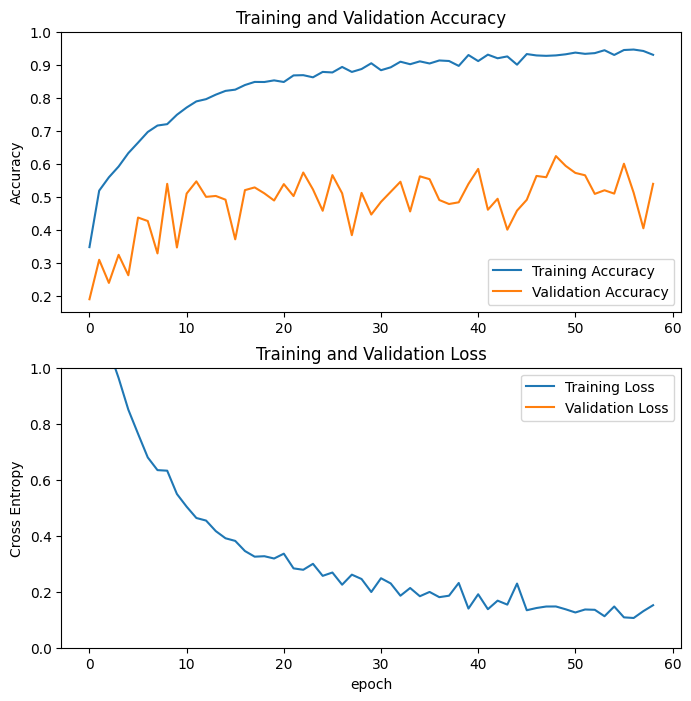

highest validation accuracy 62.31
with train accuracy 92.82
on epoch 49

--------Results for fold1---------------
max val_acc per iteration: [(0, 0.87), (1, 0.86), (2, 0.9), (3, 0.9), (4, 0.85), (5, 0.86), (6, 0.81), (7, 0.91), (8, 0.84), (9, 0.88)]
highest val_acc: 0.91
mean max: tf.Tensor(0.86800003, shape=(), dtype=float32) std_dev: tf.Tensor(0.029257474, shape=(), dtype=float32)


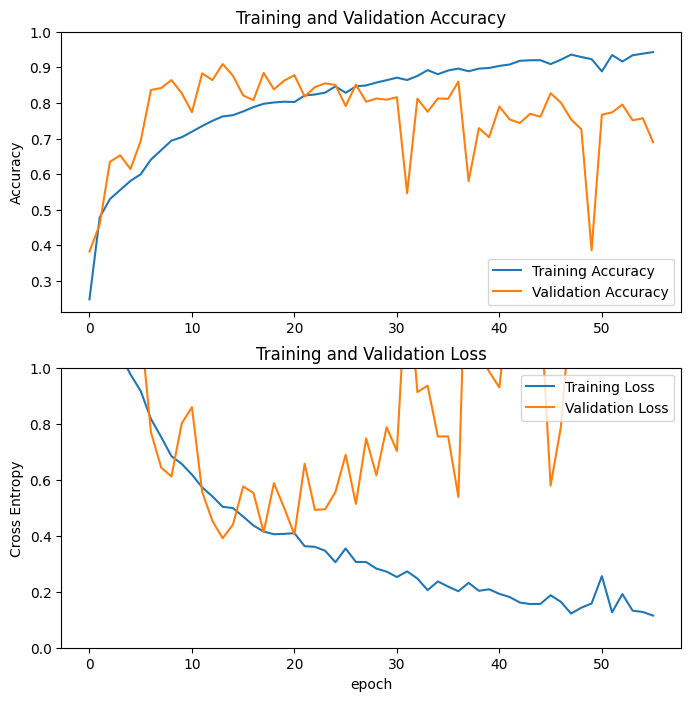

highest validation accuracy 90.92
with train accuracy 76.21
on epoch 14

--------Results for fold2---------------
max val_acc per iteration: [(0, 0.57), (1, 0.6), (2, 0.61), (3, 0.59), (4, 0.63), (5, 0.61), (6, 0.66), (7, 0.64), (8, 0.6), (9, 0.63)]
highest val_acc: 0.66
mean max: tf.Tensor(0.61399996, shape=(), dtype=float32) std_dev: tf.Tensor(0.024979996, shape=(), dtype=float32)


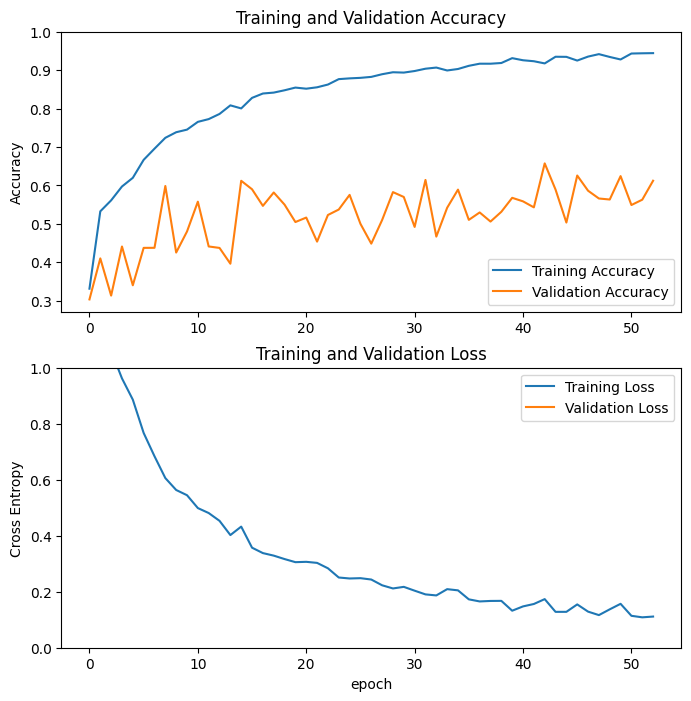

highest validation accuracy 65.73
with train accuracy 91.75
on epoch 43

--------Results for fold3---------------
max val_acc per iteration: [(0, 0.51), (1, 0.6), (2, 0.59), (3, 0.67), (4, 0.45), (5, 0.53), (6, 0.55), (7, 0.55), (8, 0.55), (9, 0.45)]
highest val_acc: 0.67
mean max: tf.Tensor(0.54499996, shape=(), dtype=float32) std_dev: tf.Tensor(0.06344289, shape=(), dtype=float32)


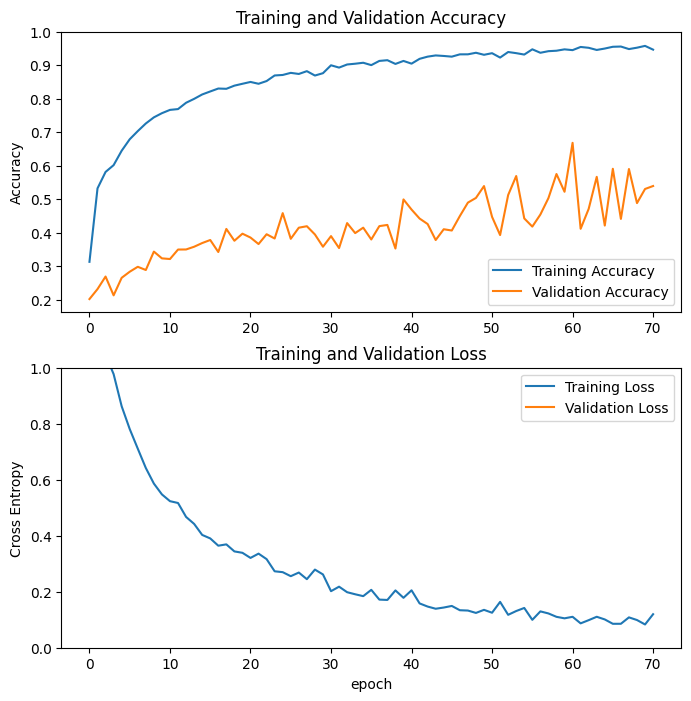

highest validation accuracy 66.85
with train accuracy 94.51
on epoch 61

--------Results for fold4---------------
max val_acc per iteration: [(0, 0.52), (1, 0.52), (2, 0.48), (3, 0.47), (4, 0.48), (5, 0.52), (6, 0.5), (7, 0.6), (8, 0.46), (9, 0.48)]
highest val_acc: 0.6
mean max: tf.Tensor(0.503, shape=(), dtype=float32) std_dev: tf.Tensor(0.038483765, shape=(), dtype=float32)


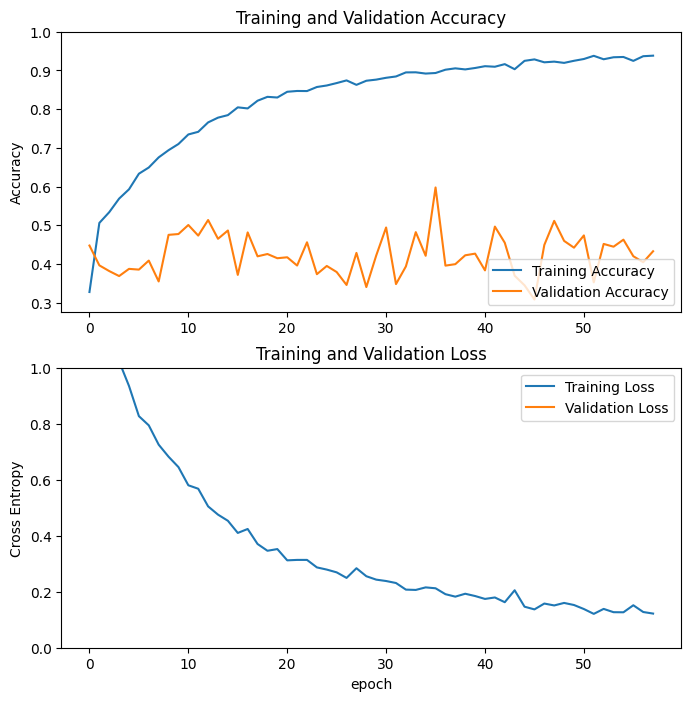

highest validation accuracy 59.76
with train accuracy 89.33
on epoch 36

--------Results for fold5---------------
max val_acc per iteration: [(0, 0.63), (1, 0.69), (2, 0.67), (3, 0.62), (4, 0.68), (5, 0.63), (6, 0.65), (7, 0.65), (8, 0.68), (9, 0.64)]
highest val_acc: 0.69
mean max: tf.Tensor(0.654, shape=(), dtype=float32) std_dev: tf.Tensor(0.023323812, shape=(), dtype=float32)


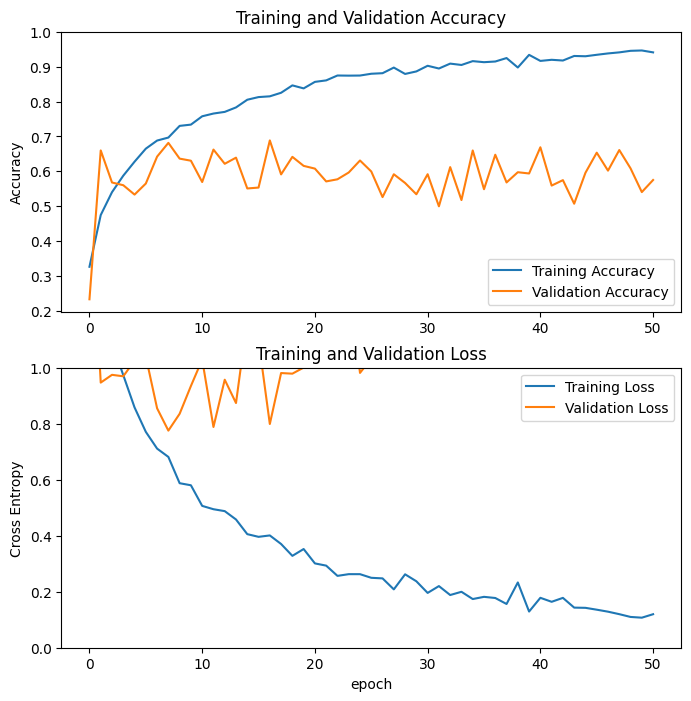

highest validation accuracy 68.85
with train accuracy 81.49
on epoch 17

--------Results for fold6---------------
max val_acc per iteration: [(0, 0.34), (1, 0.4), (2, 0.35), (3, 0.29), (4, 0.32), (5, 0.3), (6, 0.41), (7, 0.41), (8, 0.37), (9, 0.36)]
highest val_acc: 0.41
mean max: tf.Tensor(0.35500002, shape=(), dtype=float32) std_dev: tf.Tensor(0.041291647, shape=(), dtype=float32)


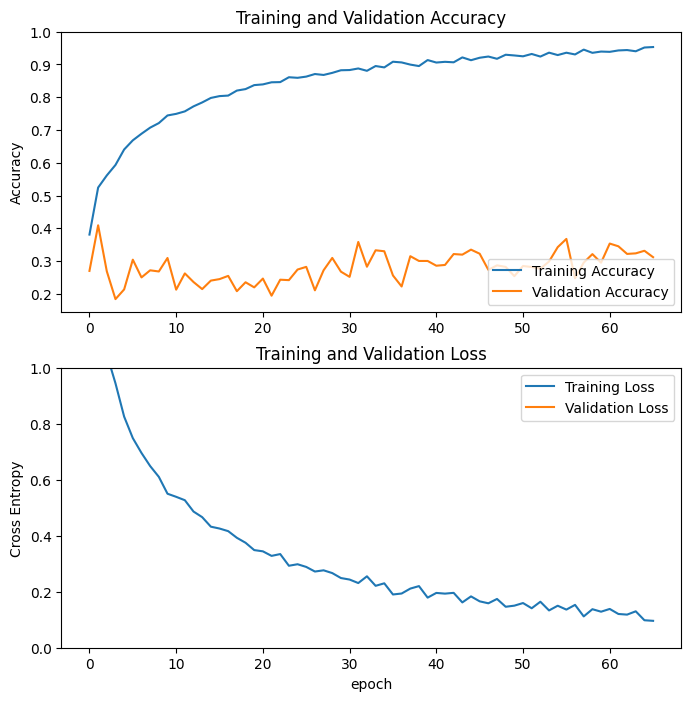

highest validation accuracy 40.95
with train accuracy 52.46
on epoch 2

--------Results for fold7---------------
max val_acc per iteration: [(0, 0.52), (1, 0.51), (2, 0.39), (3, 0.49), (4, 0.47), (5, 0.38), (6, 0.4), (7, 0.4), (8, 0.49), (9, 0.45)]
highest val_acc: 0.52
mean max: tf.Tensor(0.45, shape=(), dtype=float32) std_dev: tf.Tensor(0.05059644, shape=(), dtype=float32)


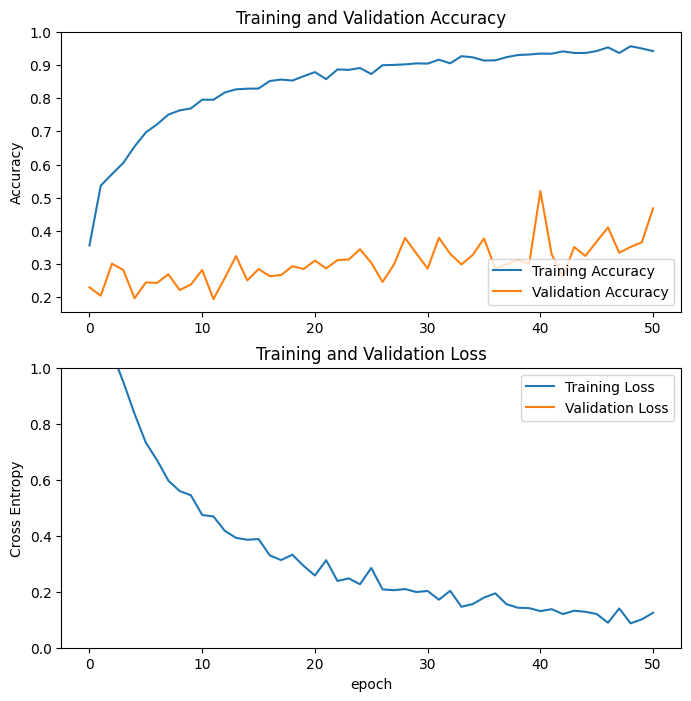

highest validation accuracy 52.01
with train accuracy 93.41
on epoch 41

--------Results for fold8---------------
max val_acc per iteration: [(0, 0.7), (1, 0.71), (2, 0.77), (3, 0.64), (4, 0.78), (5, 0.89), (6, 0.73), (7, 0.8), (8, 0.8), (9, 0.75)]
highest val_acc: 0.89
mean max: tf.Tensor(0.75699997, shape=(), dtype=float32) std_dev: tf.Tensor(0.06481513, shape=(), dtype=float32)


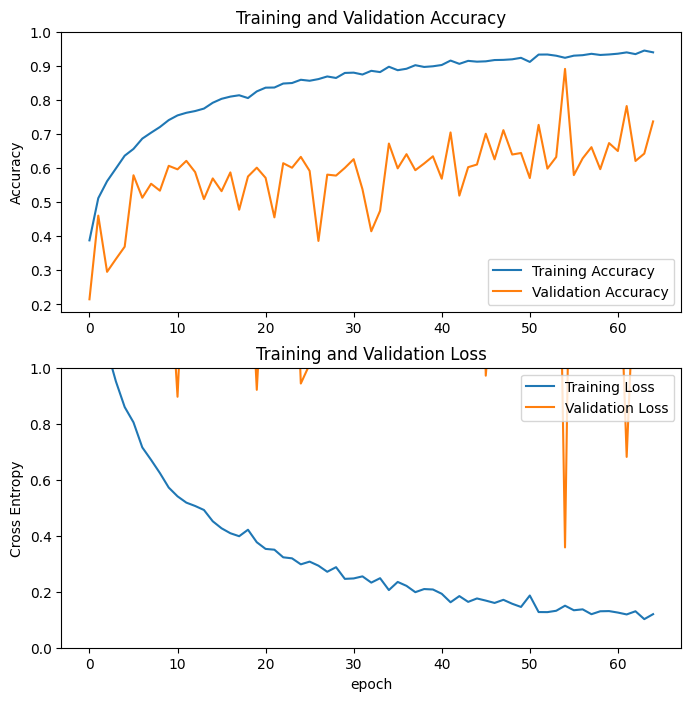

highest validation accuracy 89.10
with train accuracy 92.35
on epoch 55

--------Results for fold9---------------
max val_acc per iteration: [(0, 0.6), (1, 0.62), (2, 0.64), (3, 0.6), (4, 0.63), (5, 0.6), (6, 0.59), (7, 0.62), (8, 0.58), (9, 0.59)]
highest val_acc: 0.64
mean max: tf.Tensor(0.607, shape=(), dtype=float32) std_dev: tf.Tensor(0.018466188, shape=(), dtype=float32)


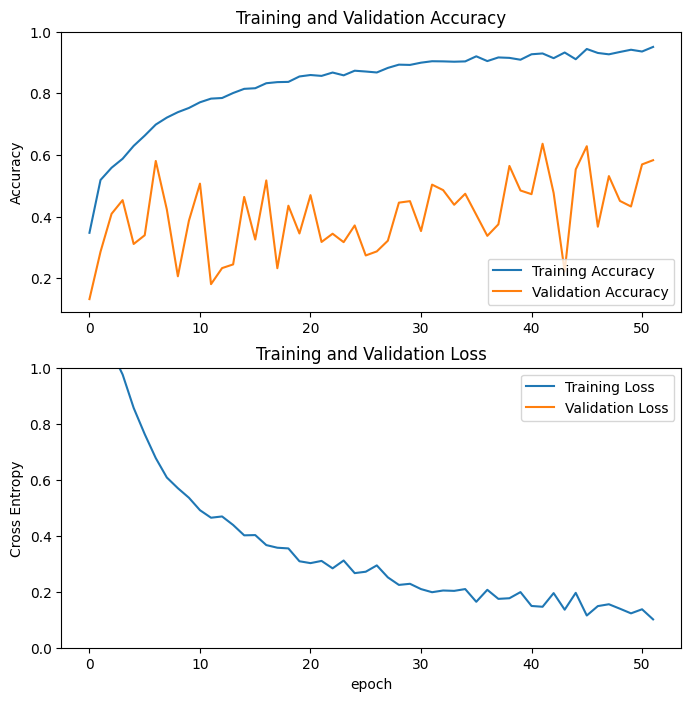

highest validation accuracy 63.66
with train accuracy 92.95
on epoch 42

--------Results for fold10---------------
max val_acc per iteration: [(0, 0.55), (1, 0.6), (2, 0.57), (3, 0.55), (4, 0.5), (5, 0.55), (6, 0.53), (7, 0.53), (8, 0.55), (9, 0.52)]
highest val_acc: 0.6
mean max: tf.Tensor(0.54499996, shape=(), dtype=float32) std_dev: tf.Tensor(0.026172515, shape=(), dtype=float32)


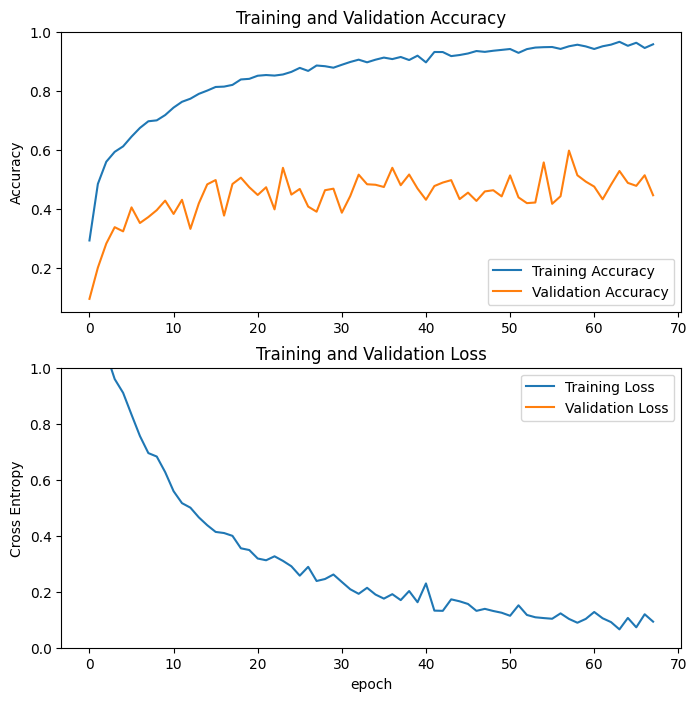

highest validation accuracy 59.77
with train accuracy 95.07
on epoch 58

--------Results for fold11---------------
max val_acc per iteration: [(0, 0.63), (1, 0.63), (2, 0.6), (3, 0.6), (4, 0.57), (5, 0.75), (6, 0.73), (7, 0.63), (8, 0.67), (9, 0.77)]
highest val_acc: 0.77
mean max: tf.Tensor(0.658, shape=(), dtype=float32) std_dev: tf.Tensor(0.06569627, shape=(), dtype=float32)


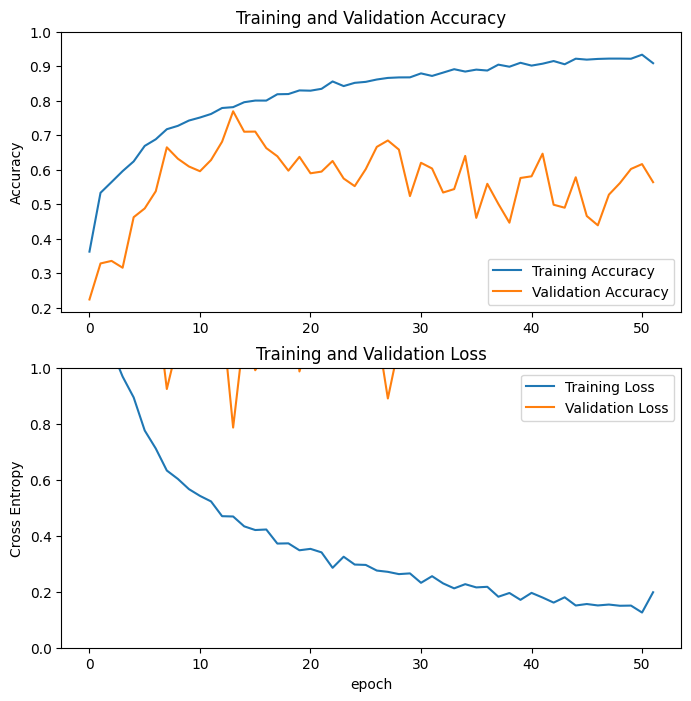

highest validation accuracy 76.94
with train accuracy 78.14
on epoch 14

--------Results for fold12---------------
max val_acc per iteration: [(0, 0.73), (1, 0.64), (2, 0.75), (3, 0.66), (4, 0.59), (5, 0.64), (6, 0.64), (7, 0.61), (8, 0.69), (9, 0.72)]
highest val_acc: 0.75
mean max: tf.Tensor(0.667, shape=(), dtype=float32) std_dev: tf.Tensor(0.050606333, shape=(), dtype=float32)


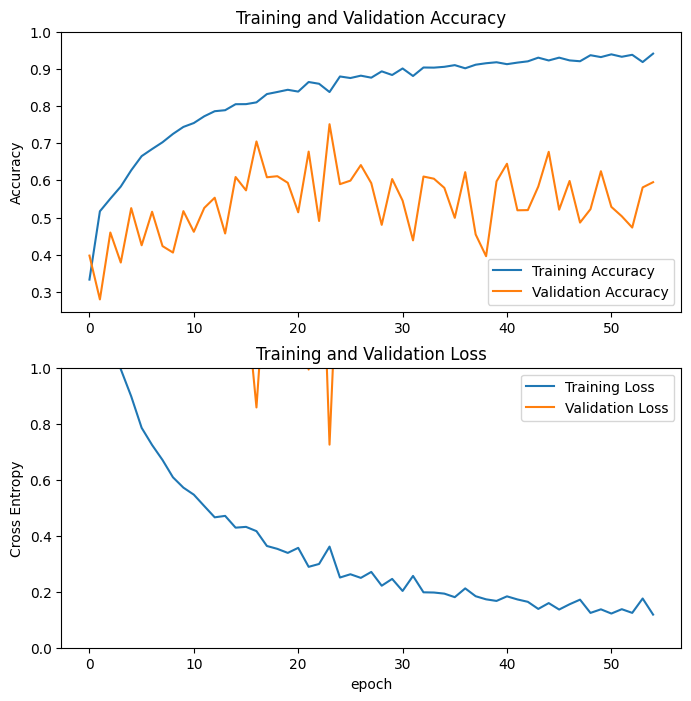

highest validation accuracy 75.11
with train accuracy 83.77
on epoch 24

--------Results for fold13---------------
max val_acc per iteration: [(0, 0.55), (1, 0.56), (2, 0.54), (3, 0.51), (4, 0.53), (5, 0.54), (6, 0.5), (7, 0.51), (8, 0.58), (9, 0.53)]
highest val_acc: 0.58
mean max: tf.Tensor(0.53499997, shape=(), dtype=float32) std_dev: tf.Tensor(0.023345236, shape=(), dtype=float32)


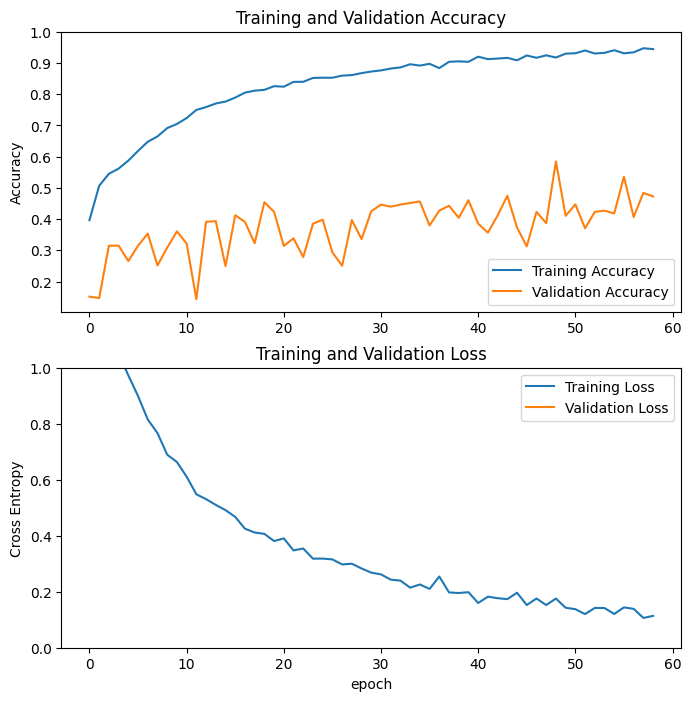

highest validation accuracy 58.47
with train accuracy 91.73
on epoch 49

--------Results for fold14---------------
max val_acc per iteration: [(0, 0.63), (1, 0.61), (2, 0.6), (3, 0.6), (4, 0.58), (5, 0.59), (6, 0.56), (7, 0.65), (8, 0.6), (9, 0.57)]
highest val_acc: 0.65
mean max: tf.Tensor(0.59900004, shape=(), dtype=float32) std_dev: tf.Tensor(0.025475476, shape=(), dtype=float32)


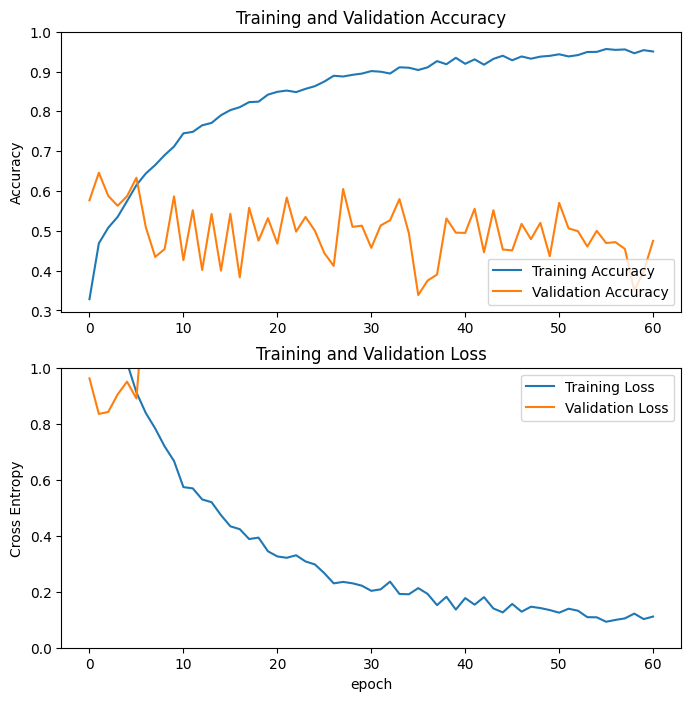

highest validation accuracy 64.60
with train accuracy 46.86
on epoch 2

--------Results for fold15---------------
max val_acc per iteration: [(0, 0.63), (1, 0.67), (2, 0.52), (3, 0.62), (4, 0.6), (5, 0.71), (6, 0.68), (7, 0.58), (8, 0.62), (9, 0.63)]
highest val_acc: 0.71
mean max: tf.Tensor(0.62600005, shape=(), dtype=float32) std_dev: tf.Tensor(0.051029406, shape=(), dtype=float32)


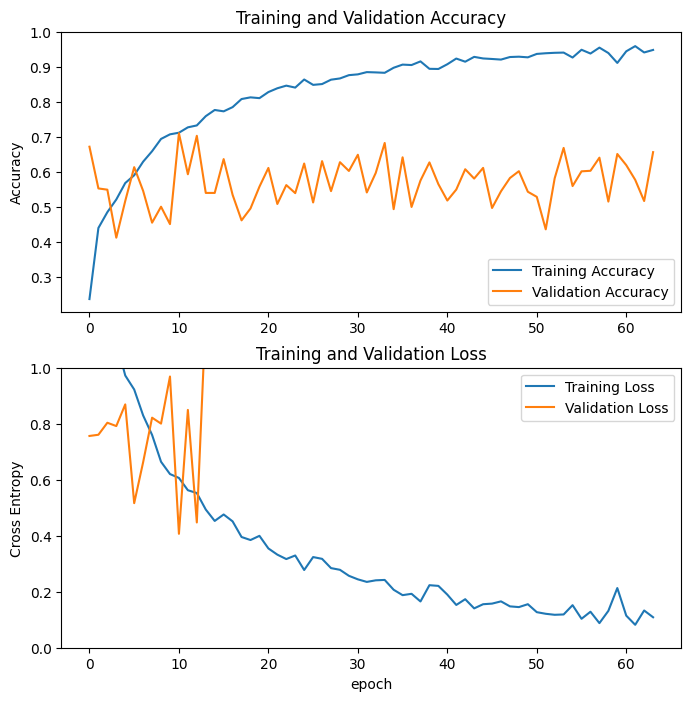

highest validation accuracy 71.03
with train accuracy 71.17
on epoch 11

--------Results for fold16---------------
max val_acc per iteration: [(0, 0.6), (1, 0.71), (2, 0.59), (3, 0.62), (4, 0.53), (5, 0.58), (6, 0.68), (7, 0.58), (8, 0.63), (9, 0.64)]
highest val_acc: 0.71
mean max: tf.Tensor(0.616, shape=(), dtype=float32) std_dev: tf.Tensor(0.0496387, shape=(), dtype=float32)


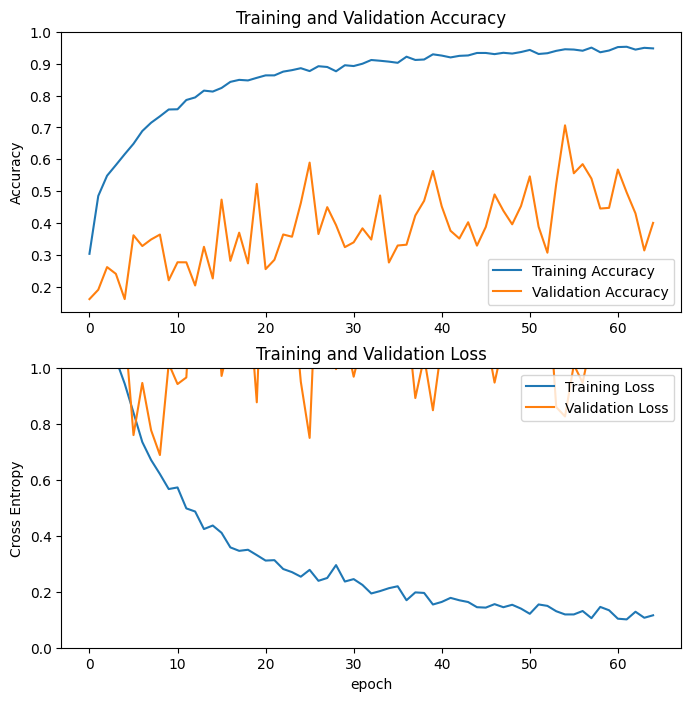

highest validation accuracy 70.66
with train accuracy 94.50
on epoch 55


In [38]:
loocv_trainer.show_results(spectrum_unet_loocv_trainer)

In [39]:
spectrum_unet_loocv_trainer.show_results()

max val_acc per iteration: [(0, 0.59), (1, 0.56), (2, 0.59), (3, 0.59), (4, 0.54), (5, 0.62), (6, 0.62), (7, 0.57), (8, 0.56), (9, 0.61), (10, 0.87), (11, 0.86), (12, 0.9), (13, 0.9), (14, 0.85), (15, 0.86), (16, 0.81), (17, 0.91), (18, 0.84), (19, 0.88), (20, 0.57), (21, 0.6), (22, 0.61), (23, 0.59), (24, 0.63), (25, 0.61), (26, 0.66), (27, 0.64), (28, 0.6), (29, 0.63), (30, 0.51), (31, 0.6), (32, 0.59), (33, 0.67), (34, 0.45), (35, 0.53), (36, 0.55), (37, 0.55), (38, 0.55), (39, 0.45), (40, 0.52), (41, 0.52), (42, 0.48), (43, 0.47), (44, 0.48), (45, 0.52), (46, 0.5), (47, 0.6), (48, 0.46), (49, 0.48), (50, 0.63), (51, 0.69), (52, 0.67), (53, 0.62), (54, 0.68), (55, 0.63), (56, 0.65), (57, 0.65), (58, 0.68), (59, 0.64), (60, 0.34), (61, 0.4), (62, 0.35), (63, 0.29), (64, 0.32), (65, 0.3), (66, 0.41), (67, 0.41), (68, 0.37), (69, 0.36), (70, 0.52), (71, 0.51), (72, 0.39), (73, 0.49), (74, 0.47), (75, 0.38), (76, 0.4), (77, 0.4), (78, 0.49), (79, 0.45), (80, 0.7), (81, 0.71), (82, 0.77)